# Inversion process using SOS Algorithm

In [92]:
import numpy as np
import random as r
import matplotlib.pyplot as plt

Function definition

In [93]:
import numpy as np
import math as m

def FWD_MT1D(rho, thickness, period):
    global w, Zn, dj, wj, ej, rj, re, Zj, Z, apparent_resistivity, phase
    nd = len(period)  # number of datas
    Z = np.zeros(nd, dtype=complex)
    apparent_resistivity = np.zeros(nd)
    phase = np.zeros(nd)

    for i in range(nd):
        mp = 4 * m.pi * 10 ** -7  # magnetic permeability
        w = 2 * m.pi / period[i]  # angular frequency
        nl = len(rho)  # number of layers
        impedances = np.zeros(nl, dtype=complex)

        # calculate basement impedance
        impedances[nl - 1] = np.sqrt(complex(0, w * mp * rho[nl - 1]))

        for j in range(nl - 2, -1, -1):
            R = rho[j]
            H = thickness[j]

            # iteratively calculated the apparent resistivity from bottom to top layer
            dj = np.sqrt(complex(0, w * mp / R))
            wj = dj * R
            ej = np.exp(-2 * H * dj)

            belowImpedance = impedances[j + 1]
            rj = (wj - belowImpedance) / (wj + belowImpedance)
            re = rj * ej
            Zj = wj * ((1 - re) / (1 + re))
            impedances[j] = Zj

        Z[i] = impedances[0]
        apparent_resistivity[i] = (abs(Z[i]) * abs(Z[i])) / (mp * w)
        phase[i] = np.arctan([Z[i].imag / Z[i].real]) * 180 / m.pi

    return apparent_resistivity, phase

def misfit_MT(rho_cal, rho_obs, phase_cal, phase_obs):
    global a, b, d2r, nd, e, misfit
    a = rho_cal
    b = phase_cal
    d2r = m.pi/180 #degree to radian
    nd = len(rho_obs) #length of data
    e = np.zeros(nd)
    for k in range (nd):
        e[k] =abs(m.log10(a[k]/rho_obs[k]))+abs(d2r*(b[k]-phase_obs[k]))
    return (sum(e)/nd)

In [94]:
# Create synthetic data
# In this example I used 3 layers model with parameter stated below

r_layer = [100, 10, 1000]  # resistivity of each layer
t_layer = [500, 1500]  # thickness of each layer
period = np.logspace(-3, 3, 50)  # period from 10^-3 to 10^3 divide into 50 points
ndata = len(period)
lyr = len(r_layer) # number of layers

# Generate synthetic data
rho_data, phase_data = FWD_MT1D(r_layer, t_layer, period)

Plot synthetic model and data

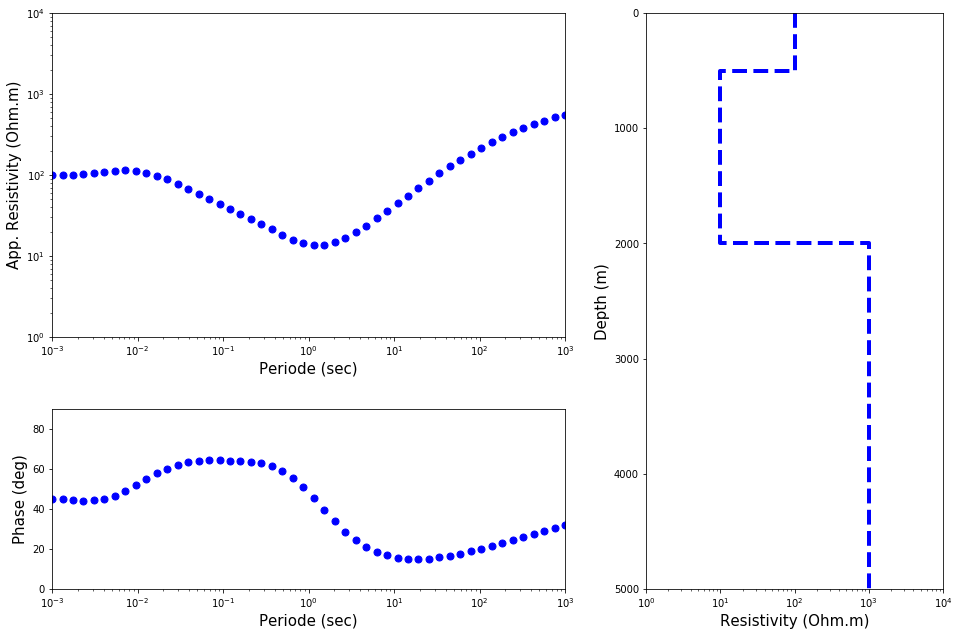

In [95]:
plot_res_obs = np.zeros(2 * lyr)
plot_thi_obs = np.zeros(2 * lyr)
for i in range(lyr):
    plot_res_obs[2 * i] = r_layer[i]
    plot_res_obs[2 * i + 1] = r_layer[i]
plot_thi_obs[0] = 0
plot_thi_obs[2 * lyr - 1] = 10000
for i in range(lyr - 1):
    plot_thi_obs[2 * i + 1] = plot_thi_obs[2 * i] + t_layer[i]
    plot_thi_obs[2 * i + 2] = plot_thi_obs[2 * i] + t_layer[i]
    
plt.figure(figsize=(15, 10))
plt.axes([0.1, 0.45, 0.475, 0.45])
plt.loglog(period, rho_data, '.', color='blue', markersize=14, label='observed')
plt.xlim([0.001, 1000])
plt.ylim([1, 10000])
plt.xlabel('Periode (sec)', fontsize=15)
plt.ylabel('App. Resistivity (Ohm.m)', fontsize=15)

plt.axes([0.1, 0.1, 0.475, 0.25])
plt.semilogx(period, phase_data, '.', color='blue', markersize=14, label='observed')
plt.xlim([0.001, 1000])
plt.ylim([0, 90])
plt.xlabel('Periode (sec)', fontsize=15)
plt.ylabel('Phase (deg)', fontsize=15)

plt.axes([0.65, 0.1, 0.275, 0.8])
plt.step(plot_res_obs, plot_thi_obs, color='blue', linestyle='--', linewidth=4, label='Observe')
plt.xscale('log')
plt.xlim([1, 10 ** 4])
plt.ylim([0, 5000])
plt.gca().invert_yaxis()
plt.xlabel('Resistivity (Ohm.m)', fontsize=15)
plt.ylabel('Depth (m)', fontsize=15)

plt.show()

In [96]:
# Model space

npop = 50  # number of populations
ngen = 50  # number of iteration/generation

r_min = 1  # minimum value of resistivity
r_max = 1500  # maximum value of resistivity
h_min = 200  # minimum value of thickness
h_max = 2000  # maximum value of thickness

In [97]:
# Generate initial model

res = np.zeros((npop, lyr))
thick = np.zeros((npop, lyr - 1))
for ip in range(npop):
    for im in range(lyr):
        res[ip][im] = r_min + r.random() * (r_max - r_min)
    for im in range(lyr - 1):
        thick[ip][im] = h_min + r.random() * (h_max - h_min)

In [98]:
# Calculate apparent resistivity and phase for each model, and generate misfit of each model

rho_mod = np.zeros((npop, ndata))
phase_mod = np.zeros((npop, ndata))
misfit = np.zeros(npop)
for ip in range(npop):
    rho_mod[ip], phase_mod[ip] = FWD_MT1D(res[ip], thick[ip], period)
    misfit[ip] = misfit_MT(rho_mod[ip], rho_data, phase_mod[ip], phase_data)

In [99]:
# Inversion process
# We generate the inversion for 50 iterations

misfit_inv = []
for it in range(ngen):
    for ip in range(npop):
        idx = np.argmin(misfit)  # index that shows model with minimum misfit
        res_best = res[idx]
        thick_best = thick[idx]

        # mutualism phase
        j = r.randint(0, npop - 1)
        k = r.randint(0, npop - 1)
        while ip == j | ip == k:
            j = r.randint(0, npop - 1)
            k = r.randint(0, npop - 1)

        # model tested and targeted model
        res_tes = res[ip], res[j]
        thick_tes = thick[ip], thick[j]

        res_mut = np.zeros((2, lyr))
        thick_mut = np.zeros((2, lyr-1))
        rho_mut = np.zeros((2, ndata))
        phase_mut = np.zeros((2, ndata))
        misfit_mut = np.zeros(2)
        for i in range(2):
            for im in range(lyr):
                res_mut[i][im] = res_tes[i][im] + r.random() * (res[k][im] - ((res[ip][im] + res[j][im]) / 2))
                if res_mut[i][im] < r_min:
                    res_mut[i][im] = r_min
                if res_mut[i][im] > r_max:
                    res_mut[i][im] = r_max
            for im in range(lyr-1):
                thick_mut[i][im] = thick_tes[i][im] + r.random() * (thick[k][im] - ((thick[ip][im] + thick[j][im]) / 2))
                if thick_mut[i][im] < h_min:
                    thick_mut[i][im] = h_min
                if thick_mut[i][im] > h_max:
                    thick_mut[i][im] = h_max

            rho_mut[i], phase_mut[i] = FWD_MT1D(res_mut[i], thick_mut[i], period)
            misfit_mut[i] = misfit_MT(rho_mut[i], rho_data, phase_mut[i], phase_data)

        if misfit_mut[0] < misfit[ip]:
            misfit[ip] = misfit_mut[0]
            res[ip] = res_mut[0]
            thick[ip] = thick_mut[0]
            rho_mod[ip] = rho_mut[0]
            phase_mod[ip] = phase_mut[0]
        if misfit_mut[1] < misfit[j]:
            misfit[j] = misfit_mut[1]
            res[j] = res_mut[1]
            thick[j] = thick_mut[1]
            rho_mod[j] = rho_mut[1]
            phase_mod[j] = phase_mut[1]

        # commensalism phase
        j = r.randint(0, npop - 1)
        while j == ip:
            j = r.randint(0, npop - 1)

        res_com = np.zeros(lyr)
        thick_com = np.zeros(lyr-1)
        for im in range(lyr):
            res_com[im] = res[ip][im] + (0.4 + 0.5 * r.random()) * (res_best[im] - res[j][im])
            if res_com[im] < r_min:
                res_com[im] = r_min
            if res_com[im] > r_max:
                res_com[im] = r_max
        for im in range(lyr-1):
            thick_com[im] = thick[ip][im] + (0.4 + 0.5 * r.random()) * (thick_best[im] - thick[j][im])
            if thick_com[im] < h_min:
                thick_com[im] = h_min
            if thick_com[im] > h_max:
                thick_com[im] = h_max
                
        rho_com, phase_com = FWD_MT1D(res_com, thick_com, period)
        misfit_com = misfit_MT(rho_com, rho_data, phase_com, phase_data)

        if misfit_com < misfit[ip]:
            misfit[ip] = misfit_com
            res[ip] = res_com
            thick[ip] = thick_com
            rho_mod[ip] = rho_com
            phase_mod[ip] = phase_com

        # parasitism phase
        j = r.randint(0, npop - 1)
        while j == ip:
            j = r.randint(0, npop - 1)

        res_par = res[ip]
        thick_par = thick[ip]
        p = r.randint(0, 1)
        if p == 0:
            p1 = r.randint(0, lyr-1)
            res_par[p1] = r_min + r.random() * (r_max - r_min)
        else:
            p2 = r.randint(0, lyr-2)
            thick_par[p2] = h_min + r.random() * (h_max - h_min)
            
        rho_par, phase_par = FWD_MT1D(res_par, thick_par, period)
        misfit_par = misfit_MT(rho_par, rho_data, phase_par, phase_data)

        if misfit_par < misfit[j]:
            misfit[j] = misfit_par
            res[j] = res_par
            thick[j] = thick_par
            rho_mod[j] = rho_par
            phase_mod[j] = phase_par

    # best model
    Emin = 100
    for ipop in range(npop):
        if misfit[ipop] < Emin:
            Emin = misfit[ipop]
            res_inv = res[ipop]
            thick_inv = thick[ipop]
            rho_inv = rho_mod[ipop]
            phase_inv = phase_mod[ipop]
    misfit_inv.append(Emin)

In [100]:
# Plotting
plot_res_obs = np.zeros(2 * lyr)
plot_res_inv = np.zeros(2 * lyr)
plot_thi_obs = np.zeros(2 * lyr)
plot_thi_inv = np.zeros(2 * lyr)
for i in range(lyr):
    plot_res_obs[2 * i] = r_layer[i]
    plot_res_obs[2 * i + 1] = r_layer[i]
    plot_res_inv[2 * i] = res_inv[i]
    plot_res_inv[2 * i + 1] = res_inv[i]
plot_thi_obs[0] = 0
plot_thi_obs[2 * lyr - 1] = 10000
plot_thi_inv[0] = 0
plot_thi_inv[2 * lyr - 1] = 10000
for i in range(lyr - 1):
    plot_thi_obs[2 * i + 1] = plot_thi_obs[2 * i] + t_layer[i]
    plot_thi_obs[2 * i + 2] = plot_thi_obs[2 * i] + t_layer[i]
    plot_thi_inv[2 * i + 1] = plot_thi_inv[2 * i] + thick_inv[i]
    plot_thi_inv[2 * i + 2] = plot_thi_inv[2 * i] + thick_inv[i]

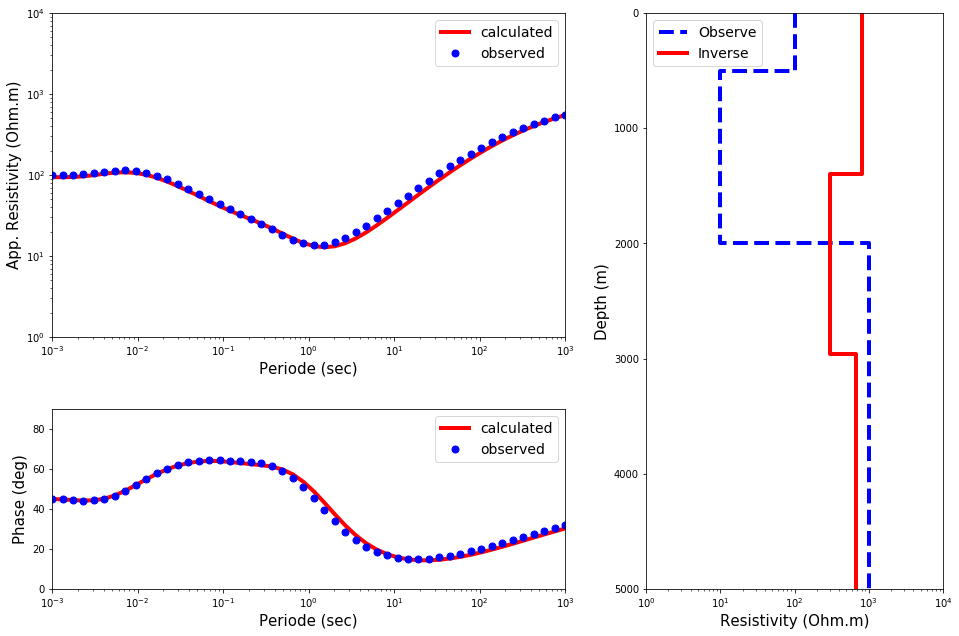

Text(0, 0.5, 'Misfit')

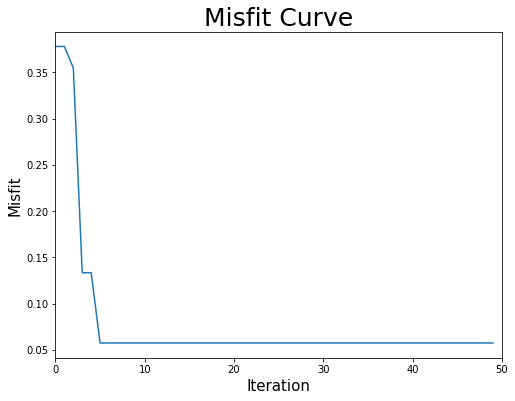

In [101]:
# figure 1
# App. resistivity vs Period
plt.figure(figsize=(15, 10))
plt.axes([0.1, 0.45, 0.475, 0.45])
plt.loglog(period, rho_inv, color='red', linewidth=4, label='calculated')
plt.loglog(period, rho_data, '.', color='blue', markersize=14, label='observed')
plt.xlim([0.001, 1000])
plt.ylim([1, 10000])
plt.xlabel('Periode (sec)', fontsize=15)
plt.ylabel('App. Resistivity (Ohm.m)', fontsize=15)
plt.legend(prop={'size': 14})

# Phase vs Period
plt.axes([0.1, 0.1, 0.475, 0.25])
plt.semilogx(period, phase_inv, color='red', linewidth=4, label='calculated')
plt.semilogx(period, phase_data, '.', color='blue', markersize=14, label='observed')
plt.xlim([0.001, 1000])
plt.ylim([0, 90])
plt.xlabel('Periode (sec)', fontsize=15)
plt.ylabel('Phase (deg)', fontsize=15)
plt.legend(prop={'size': 14})

# resist vs depth
plt.axes([0.65, 0.1, 0.275, 0.8])
plt.step(plot_res_obs, plot_thi_obs, color='blue', linestyle='--', linewidth=4, label='Observe')
plt.step(plot_res_inv, plot_thi_inv, color='red', linestyle='-', linewidth=4, label='Inverse')
plt.xscale('log')
plt.xlim([1, 10 ** 4])
plt.ylim([0, 5000])
plt.gca().invert_yaxis()
plt.xlabel('Resistivity (Ohm.m)', fontsize=15)
plt.ylabel('Depth (m)', fontsize=15)
plt.legend(prop={'size': 14})
plt.show()

# figure 2
x = list(range(ngen))
plt.figure(figsize=(8, 6))
plt.plot(x, misfit_inv)
plt.xlim([0, ngen])
plt.title('Misfit Curve', fontsize=25)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Misfit', fontsize=15)